In [2]:
import pandas as pd
import xarray as xr
import glob
import os
import netCDF4
import scipy
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix 
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
#from oceans.filters import lanc  #pip install ocean
import cartopy as cart
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs

In [3]:
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

In [4]:
#/nfs/public_ads/Oelsmann/marcello/gesla_v2/gesla_v2_northsea_balticsea.nc


region = 'BALTIC'

start_time = '01/01/2004'

end_time = '31/12/2004'

if region in {'BALTIC'} :
    max_lat = 66.0
    min_lat = 53.0
    max_lon = 31.0
    min_lon = 9.0
    
    #tg_dac = xr.open_dataset('/nfs/DGFI8/H/work_marcello/giussani_machinelearning_data/TG_DACcorrected/baltic_tg_gesla_dac.nc')
    tg_dac = xr.open_dataset('/nfs/public_ads/Oelsmann/marcello/gesla_v2/gesla_v2_northsea_balticsea.nc')

    lon = np.asarray(tg_dac.lon.values,dtype=float)
    lat = np.asarray(tg_dac.lat.values,dtype=float)    
    
#     # Exclude tide gauges in Kattegat and Skagerrag, because out of the training area

    indices =  ~( (lon < 13.0) & (lon > 9) &   \
                              (lat < 66.0) & (lat > 56.0)) & ((lon < max_lon) & (lon > min_lon) &   \
                              (lat < max_lat) & (lat > min_lat))   
    

    # Altimetry
    alti_full = pd.read_csv(r'/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_baltic2004_01to12.csv',index_col=[0],parse_dates=[0])
    
    #model
    copernicus_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_copernicus.csv',index_col=[7],parse_dates=[7])
    copernicus_full['sla_predicted'] = copernicus_full['sla_predicted'] 

    #cmems
    cmems_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_cmems_allsat.csv',index_col=[5],parse_dates=[5])    
    

elif region in {'NORTHSEA'} :
    
    max_lat = 61.0
    min_lat = 50.0
    max_lon = 12.2
    min_lon = -4.0  
    
    tg_dac = xr.open_dataset('/nfs/public_ads/Oelsmann/marcello/gesla_v2/gesla_v2_northsea_balticsea.nc')
    
    lon = np.asarray(tg_dac.lon.values,dtype=float)
    lat = np.asarray(tg_dac.lat.values,dtype=float)
    
    indices =  ( (lon < max_lon) & (lon > min_lon) &   \
                              (lat < max_lat) & (lat > min_lat) )    

    # Altimetry
    alti_full = pd.read_csv(r'/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_northsea2004_01to12.csv',index_col=[0],parse_dates=[0])
    
    #model
    copernicus_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_copernicus.csv',index_col=[7],parse_dates=[7])
    copernicus_full['sla_predicted'] = copernicus_full['sla_predicted'] 

    #cmems
    cmems_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_cmems_NORTHSEA_allsat.csv',index_col=[5],parse_dates=[5])



tg_dac = tg_dac.sel({'x':indices })

tg_dac


<xarray.Dataset>
Dimensions:  (time: 32677, x: 30)
Coordinates:
    lon      (x) float64 12.89 21.46 19.01 22.69 ... 16.48 25.42 14.36 12.83
    lat      (x) float64 55.52 61.59 63.19 63.71 ... 57.27 65.04 55.56 55.42
  * time     (time) datetime64[ns] 1993-01-01 1993-01-01T06:00:00 ... 2015-05-15
    index    (x) int64 ...
Dimensions without coordinates: x
Data variables:
    sla      (time, x) float64 ...
Attributes:
    info:     GESLAv2 dataset; DAC and Tide removed (with 40-h loess filter).

In [5]:
# Distance vs TG
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371
    phi1 = np.radians(lat1)
    
    
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 -lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))

    return np.round(res, 2)

/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(10)
Coordinates:
    lon      float64 12.89
    lat      float64 55.52
    index    int64 10
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.836578  0.959670  0.920267
model  0.836578  1.000000  0.833829  0.888387
cmems  0.959670  0.833829  1.000000  0.911970
TG     0.920267  0.888387  0.911970  1.000000
RMSE ML TG
0.05385076059683719
RMSE CMEMS TG
0.056220746382919726


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(26)
Coordinates:
    lon      float64 21.46
    lat      float64 61.59
    index    int64 26
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.921229  0.991376  0.978424
model  0.921229  1.000000  0.921955  0.932168
cmems  0.991376  0.921955  1.000000  0.975125
TG     0.978424  0.932168  0.975125  1.000000
RMSE ML TG
0.0504500447677102
RMSE CMEMS TG
0.050901059939342096


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(92)
Coordinates:
    lon      float64 19.01
    lat      float64 63.19
    index    int64 92
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.898476  0.993308  0.963958
model  0.898476  1.000000  0.889475  0.912755
cmems  0.993308  0.889475  1.000000  0.960087
TG     0.963958  0.912755  0.960087  1.000000
RMSE ML TG
0.04436495604665019
RMSE CMEMS TG
0.048755103469211046


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(93)
Coordinates:
    lon      float64 22.69
    lat      float64 63.71
    index    int64 93
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.907198  0.988091  0.970313
model  0.907198  1.000000  0.891796  0.924055
cmems  0.988091  0.891796  1.000000  0.964940
TG     0.970313  0.924055  0.964940  1.000000
RMSE ML TG
0.044296342089749044
RMSE CMEMS TG
0.04840830053299914


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(94)
Coordinates:
    lon      float64 21.57
    lat      float64 63.08
    index    int64 94
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.913977  0.993710  0.971879
model  0.913977  1.000000  0.914304  0.932582
cmems  0.993710  0.914304  1.000000  0.971144
TG     0.971879  0.932582  0.971144  1.000000
RMSE ML TG
0.04803622102878404
RMSE CMEMS TG
0.04997618553829653


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(97)
Coordinates:
    lon      float64 17.53
    lat      float64 62.36
    index    int64 97
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.912731  0.992090  0.975260
model  0.912731  1.000000  0.904981  0.935869
cmems  0.992090  0.904981  1.000000  0.976169
TG     0.975260  0.935869  0.976169  1.000000
RMSE ML TG
0.03549991448767316
RMSE CMEMS TG
0.03408430851876062


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(104)
Coordinates:
    lon      float64 20.89
    lat      float64 63.99
    index    int64 104
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.904559  0.990883  0.969216
model  0.904559  1.000000  0.892152  0.926644
cmems  0.990883  0.892152  1.000000  0.965569
TG     0.969216  0.926644  0.965569  1.000000
RMSE ML TG
0.03900182591968956
RMSE CMEMS TG
0.04112437471706508


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(120)
Coordinates:
    lon      float64 22.1
    lat      float64 60.43
    index    int64 120
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.914728  0.992920  0.958319
model  0.914728  1.000000  0.919529  0.926902
cmems  0.992920  0.919529  1.000000  0.958918
TG     0.958319  0.926902  0.958918  1.000000
RMSE ML TG
0.057867969422419036
RMSE CMEMS TG
0.055180847658409894


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(121)
Coordinates:
    lon      float64 24.96
    lat      float64 60.15
    index    int64 121
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.903112  0.982048  0.966726
model  0.903112  1.000000  0.896732  0.939901
cmems  0.982048  0.896732  1.000000  0.963274
TG     0.966726  0.939901  0.963274  1.000000
RMSE ML TG
0.04689545983889336
RMSE CMEMS TG
0.050101139435314336


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(130)
Coordinates:
    lon      float64 21.21
    lat      float64 62.34
    index    int64 130
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.925121  0.993644  0.976060
model  0.925121  1.000000  0.924054  0.927250
cmems  0.993644  0.924054  1.000000  0.975748
TG     0.976060  0.927250  0.975748  1.000000
RMSE ML TG
0.05089216101613642
RMSE CMEMS TG
0.049476146928503


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(161)
Coordinates:
    lon      float64 22.98
    lat      float64 59.82
    index    int64 161
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.922255  0.990933  0.976438
model  0.922255  1.000000  0.931019  0.946665
cmems  0.990933  0.931019  1.000000  0.978489
TG     0.976438  0.946665  0.978489  1.000000
RMSE ML TG
0.04531395895998221
RMSE CMEMS TG
0.04536180044749303


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(166)
Coordinates:
    lon      float64 23.1
    lat      float64 65.7
    index    int64 166
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.933093  0.979004  0.965966
model  0.933093  1.000000  0.884092  0.920860
cmems  0.979004  0.884092  1.000000  0.950597
TG     0.965966  0.920860  0.950597  1.000000
RMSE ML TG
0.04547050896726039
RMSE CMEMS TG
0.05519550829925455


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(167)
Coordinates:
    lon      float64 27.18
    lat      float64 60.56
    index    int64 167
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.915566  0.979968  0.957653
model  0.915566  1.000000  0.903776  0.932252
cmems  0.979968  0.903776  1.000000  0.947016
TG     0.957653  0.932252  0.947016  1.000000
RMSE ML TG
0.05008521761367518
RMSE CMEMS TG
0.05445260999427253


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(168)
Coordinates:
    lon      float64 17.1
    lat      float64 57.37
    index    int64 168
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.915702  0.988984  0.965264
model  0.915702  1.000000  0.916696  0.937662
cmems  0.988984  0.916696  1.000000  0.969781
TG     0.965264  0.937662  0.969781  1.000000
RMSE ML TG
0.043113741940324586
RMSE CMEMS TG
0.03987426905029347


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(187)
Coordinates:
    lon      float64 21.23
    lat      float64 64.92
    index    int64 187
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.911275  0.989808  0.940271
model  0.911275  1.000000  0.915620  0.889544
cmems  0.989808  0.915620  1.000000  0.937903
TG     0.940271  0.889544  0.937903  1.000000
RMSE ML TG
0.0550170912683297
RMSE CMEMS TG
0.05649133898609935


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(189)
Coordinates:
    lon      float64 15.59
    lat      float64 56.11
    index    int64 189
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.899719  0.983139  0.956087
model  0.899719  1.000000  0.914659  0.939421
cmems  0.983139  0.914659  1.000000  0.962423
TG     0.956087  0.939421  0.962423  1.000000
RMSE ML TG
0.04385217963423045
RMSE CMEMS TG
0.041672013430170456


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

<xarray.DataArray 'index' ()>
array(205)
Coordinates:
    lon      float64 11.93
    lat      float64 54.57
    index    int64 205
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.750128  0.922660  0.839690
model  0.750128  1.000000  0.784766  0.881444
cmems  0.922660  0.784766  1.000000  0.883471
TG     0.839690  0.881444  0.883471  1.000000
RMSE ML TG
0.07869022543369412
RMSE CMEMS TG
0.06645515875992894


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(236)
Coordinates:
    lon      float64 20.38
    lat      float64 60.03
    index    int64 236
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.908237  0.993728  0.980663
model  0.908237  1.000000  0.904473  0.931487
cmems  0.993728  0.904473  1.000000  0.980489
TG     0.980663  0.931487  0.980489  1.000000
RMSE ML TG
0.04816390727581623
RMSE CMEMS TG
0.04580417937578722


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(250)
Coordinates:
    lon      float64 18.21
    lat      float64 60.41
    index    int64 250
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.916931  0.994281  0.973205
model  0.916931  1.000000  0.910546  0.940619
cmems  0.994281  0.910546  1.000000  0.973609
TG     0.973205  0.940619  0.973609  1.000000
RMSE ML TG
0.03548680350591732
RMSE CMEMS TG
0.035750238240286975


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(256)
Coordinates:
    lon      float64 16.84
    lat      float64 58.55
    index    int64 256
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.910560  0.987592  0.961580
model  0.910560  1.000000  0.910247  0.932596
cmems  0.987592  0.910247  1.000000  0.964987
TG     0.961580  0.932596  0.964987  1.000000
RMSE ML TG
0.043817805546115
RMSE CMEMS TG
0.0450487629769259


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(299)
Coordinates:
    lon      float64 18.08
    lat      float64 59.32
    index    int64 299
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.899302  0.979689  0.973531
model  0.899302  1.000000  0.865874  0.938992
cmems  0.979689  0.865874  1.000000  0.963278
TG     0.973531  0.938992  0.963278  1.000000
RMSE ML TG
0.0354130396986619
RMSE CMEMS TG
0.04362664698601196


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(321)
Coordinates:
    lon      float64 24.41
    lat      float64 64.67
    index    int64 321
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.914222  0.979020  0.963683
model  0.914222  1.000000  0.898713  0.929167
cmems  0.979020  0.898713  1.000000  0.957145
TG     0.963683  0.929167  0.957145  1.000000
RMSE ML TG
0.047669357766540014
RMSE CMEMS TG
0.05431561762753454


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(348)
Coordinates:
    lon      float64 21.43
    lat      float64 61.13
    index    int64 348
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.923811  0.993838  0.980474
model  0.923811  1.000000  0.927654  0.938333
cmems  0.993838  0.927654  1.000000  0.978516
TG     0.980474  0.938333  0.978516  1.000000
RMSE ML TG
0.04844722618893763
RMSE CMEMS TG
0.049488081124855934


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(353)
Coordinates:
    lon      float64 24.52
    lat      float64 65.67
    index    int64 353
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.935516  0.977454  0.967832
model  0.935516  1.000000  0.887176  0.916411
cmems  0.977454  0.887176  1.000000  0.944177
TG     0.967832  0.916411  0.944177  1.000000
RMSE ML TG
0.050816833514942386
RMSE CMEMS TG
0.0626122559600312


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(355)
Coordinates:
    lon      float64 12.9
    lat      float64 55.76
    index    int64 355
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.517169  0.719562  0.735060
model  0.517169  1.000000  0.833829  0.594178
cmems  0.719562  0.833829  1.000000  0.732078
TG     0.735060  0.594178  0.732078  1.000000
RMSE ML TG
0.08704856632673652
RMSE CMEMS TG
0.08760417255572608


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(361)
Coordinates:
    lon      float64 16.48
    lat      float64 57.27
    index    int64 361
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.908876  0.983670  0.966087
model  0.908876  1.000000  0.897952  0.935877
cmems  0.983670  0.897952  1.000000  0.968135
TG     0.966087  0.935877  0.968135  1.000000
RMSE ML TG
0.03799340975308031
RMSE CMEMS TG
0.03670119938867138


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(383)
Coordinates:
    lon      float64 25.42
    lat      float64 65.04
    index    int64 383
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.927691  0.975533  0.953131
model  0.927691  1.000000  0.903216  0.920767
cmems  0.975533  0.903216  1.000000  0.942573
TG     0.953131  0.920767  0.942573  1.000000
RMSE ML TG
0.05338326427929076
RMSE CMEMS TG
0.05864870180079448


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(470)
Coordinates:
    lon      float64 14.36
    lat      float64 55.56
    index    int64 470
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.893197  0.980280  0.943241
model  0.893197  1.000000  0.907228  0.941135
cmems  0.980280  0.907228  1.000000  0.957140
TG     0.943241  0.941135  0.957140  1.000000
RMSE ML TG
0.04866674137130131
RMSE CMEMS TG
0.043031131053944606


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(482)
Coordinates:
    lon      float64 12.83
    lat      float64 55.42
    index    int64 482
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.807713  0.938663  0.903076
model  0.807713  1.000000  0.798834  0.898104
cmems  0.938663  0.798834  1.000000  0.905623
TG     0.903076  0.898104  0.905623  1.000000
RMSE ML TG
0.06409056603977575
RMSE CMEMS TG
0.06230072391148165


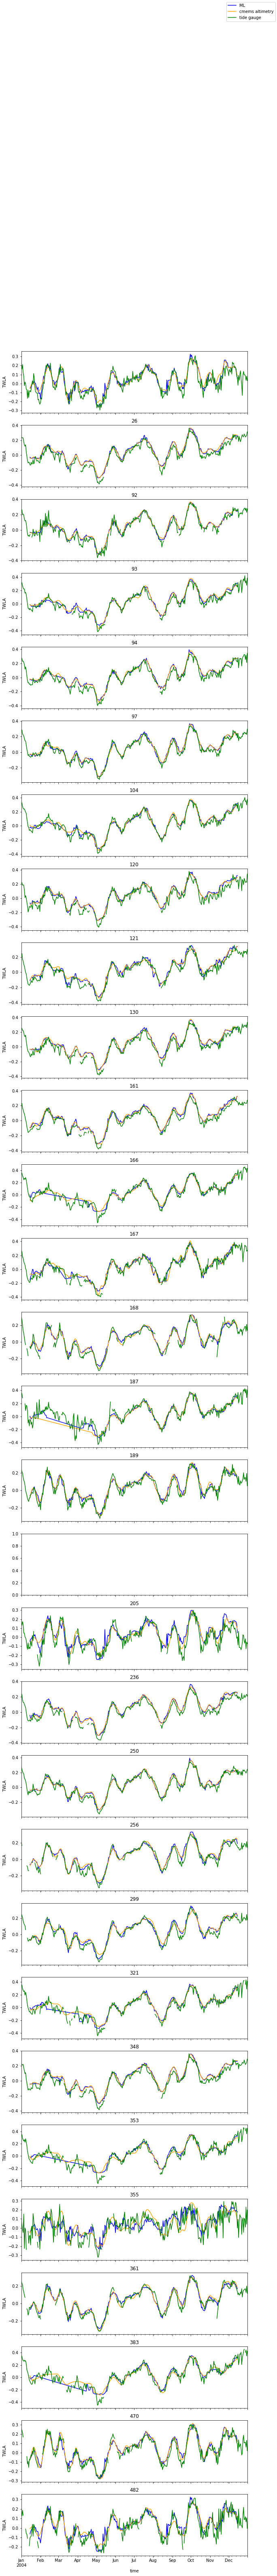

In [6]:
# list_names = ['landsortnorra-010-sweden-smhi','gedser-gedser-denmark-dmi',\
#               'visby-026-sweden-smhi']

#list_names = ['skanor-019-sweden-smhi','kungsholmsfort-008-sweden-smhi',\
#              'simrishamn-017-sweden-smhi']

list_names = ['skanor-019-sweden-smhi']

corr_ML=np.empty(np.size(tg_dac.x))*np.nan
corr_cmems=np.empty(np.size(tg_dac.x))*np.nan

rms_ML=np.empty(np.size(tg_dac.x))*np.nan
rms_cmems=np.empty(np.size(tg_dac.x))*np.nan

std_ML=np.empty(np.size(tg_dac.x))*np.nan
std_cmems=np.empty(np.size(tg_dac.x))*np.nan
std_tg=np.empty(np.size(tg_dac.x))*np.nan


row_index = np.array([0,0,0])
#col_index = np.array([0,1,2])
col_index = np.arange(0,np.size(tg_dac.x))

fig, axs = plt.subplots(np.size(tg_dac.x), 1, sharex=True, sharey=False, figsize=(10,100))

#fig_b, axs_b = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12,12))

counter = 0


#for tide_gauge_name in list_names :

for count_TG in tg_dac.x[0:] :

    #radius_of_distance_km = 100
    #tide_gauge_name='visby-026-sweden-smhi'
    
    start_lat = np.asarray(tg_dac.lat[count_TG].values,dtype=float)
    start_lon = np.asarray(tg_dac.lon[count_TG].values,dtype=float)

#     if region in {'BALTIC'} :
#         tide_gauge_name = tg_dac.name[count_TG]
#         tg_due = tg_dac.where(tg_dac.name==tide_gauge_name, drop=True)
#         tide_gauge_name = tg_dac.name[count_TG]
#     else:
    tide_gauge_name = tg_dac.index[count_TG]
    tg_due = tg_dac
    

    ## TIDE CORRECTION

    # dates = []

    # for j in range(-1,24*28*365+5):
    #      dates.append(np.array([datetime(1993, 1, 1, 0, 0, 0) + 
    # timedelta(hours=1+j)]))

    # dates = np.ravel(dates)

    # plt.figure(figsize=(15,5),dpi=320)

    # tide_correction_fes = pd.read_csv("/DGFI8/H/work_marcello/giussani_machinelearning_data/TG/landsortnorra-010-sweden-smhi_fes_ocean.txt",header=None)/100

    # plt.plot(dates,tide_correction_fes,)

    # plt.plot(tg_due.date_time,tg_due.sealevel-tide_correction_fes)
    # plt.ylabel('m')




    # initialise data of lists.
#     if region in {'BALTIC'} :
#         data = {'time':tg_due.time.values,
#                 'sla_dac':np.squeeze(tg_due.sla_dac.values)}
#     else:
    data = {'time':tg_due.time.values,
            'sla_dac':tg_due.sla[:,count_TG]}    
    #break

    # Create DataFrame
    tg = pd.DataFrame(data)
    
    # Remove mean from the tide gauge
    mean_tg_due= tg["sla_dac"].mean()
    tg.sla_dac = tg.sla_dac - tg["sla_dac"].mean()    
    median_tg_due= tg["sla_dac"].median()
    mad_tg_due= tg["sla_dac"].mad()    
    
    # Remove outliers from the tide gauge    
    tg.loc[tg["sla_dac"] > median_tg_due+1.4826*2*mad_tg_due] = np.nan
    tg.loc[tg["sla_dac"] < median_tg_due-1.4826*2*mad_tg_due] = np.nan
    
    tg=tg.set_index(tg.time)
    tg=tg.loc['2004-01-01':'2004-12-31']
    
    tg = tg.groupby(pd.Grouper(freq='24H')).mean()

    #means_tg = tg.groupby(pd.Grouper(freq='3H')).mean()
    
    

    

    #alti
    alti=alti_full.loc['2004-01-15':'2004-12-15']
    #alti_only2004=alti_only2004.loc['2004-11-20':'2004-11-29']
    copernicus=copernicus_full.loc['2004-01-15':'2004-12-15']
    cmems=cmems_full.loc['2004-01-15':'2004-12-15']
    
    

    # Compute distances from tide gauges 
    
    distances_km = haversine_distance(start_lat, start_lon, alti.lat, alti.lon)
    #distances_km_only2004 = haversine_distance(start_lat, start_lon, alti_only2004.lat, alti_only2004.lon)
    distances_km_copernicus = haversine_distance(start_lat, start_lon, copernicus.lat, copernicus.lon) 
    distances_km_cmems = haversine_distance(start_lat, start_lon, cmems.lat, cmems.lon)

    alti['distances_km']=distances_km
    #alti_only2004['distances_km']=distances_km
    copernicus['distances_km']=distances_km_copernicus
    cmems['distances_km']=distances_km_cmems

    alti.dropna(subset = ["sla_predicted"], inplace=True)
    copernicus.dropna(subset = ["sla_predicted"], inplace=True)
    cmems.dropna(subset = ["sla_predicted"], inplace=True)
    

    #alti = alti[distances_km<radius_of_distance_km]
    #copernicus = copernicus[distances_km_copernicus<radius_of_distance_km]
    #cmems = cmems[distances_km_cmems<radius_of_distance_km]
    
    
    alti = alti.loc[alti['distances_km'] == np.nanmin(alti['distances_km'])]
    copernicus = copernicus.loc[copernicus['distances_km'] == np.nanmin(copernicus['distances_km'])]
    cmems = cmems.loc[cmems['distances_km'] == np.nanmin(cmems['distances_km'])]
    #cmems = cmems.loc[np.abs(cmems['distances_km'] - np.nanmin(alti['distances_km']))<5]
    
    

#     alti = alti.loc[alti['distances_km'] <20]
#     copernicus = copernicus.loc[copernicus['distances_km'] <20]
#     cmems = cmems.loc[cmems['distances_km'] <20]
 
    
    #alti = alti.iloc[[np.nanargmin(distances_km)]]
    #copernicus = copernicus.iloc[[np.nanargmin(distances_km_copernicus)]]
    #cmems = cmems.iloc[[np.nanargmin(distances_km_cmems)]]


    alti = alti.groupby(['time']).mean()
    copernicus = copernicus.groupby(['time']).mean()
    cmems = cmems.groupby(['time']).mean()
    
    
    #Check that time series are not too short and that they have a similar number of data
#     if np.shape(alti)[0] < 120 or np.shape(cmems)[0] < 120 or np.shape(tg.sla_dac)[0]<120 or np.shape(tg.sla_dac.values[np.isnan(tg.sla_dac.values)])[0] > 60  :
#         if counter == 0 :
#             fig.legend()        
#         counter = counter + 1
#         continue
        
    if np.shape(tg.sla_dac.values[np.isnan(tg.sla_dac.values)])[0] > 60  :
        if counter == 0 :
            fig.legend()        
        counter = counter + 1
        continue        
    
    
    freq = 1./10  # Hours
    window_size = 60
    


    
    # LOESS FILTER IN TIME
#     lowess_sm = sm.nonparametric.lowess
#     points_to_filter = 10 #100 points along-track correspond to about 60 km
#     frac_loess = points_to_filter/np.size(alti.sla_predicted)
#     alti.sla_predicted = lowess_sm(np.asarray(alti.sla_predicted),np.asarray(alti.times),frac=frac_loess,it=3, return_sorted = False,missing='drop')
#     cmems.sla_predicted = lowess_sm(np.asarray(cmems.sla_predicted),np.asarray(cmems.times),frac=frac_loess,it=3, return_sorted = False,missing='drop')
    

    # Oversample daily cmems to hourly values
    #cmems_oversample = cmems
    #cmems_oversample = cmems.resample('3H').pad()
    
    
#     means_alti = alti.groupby(pd.Grouper(freq='24H')).mean()
#     means_alti.sla_predicted = np.convolve(means_alti.sla_predicted, np.ones(7)/7, mode='same')
    
#     means_copernicus  = copernicus.groupby(pd.Grouper(freq='24H')).mean()
#     means_cmems  = cmems.groupby(pd.Grouper(freq='24H')).mean()
#     means_tg = tg.groupby(pd.Grouper(freq='24H')).mean()    
    

    # Plot of the products
    try:
        ref = alti.sla_predicted.plot(ax=axs[col_index[counter]],label="ML",title=tide_gauge_name.values,color='blue')
    except:
        pass
    #copernicus.sla_predicted.plot(ax=axs[col_index[counter]],label="model")
    try:
        cmems.sla_predicted.plot(ax=axs[col_index[counter]],label="cmems altimetry",color='orange')
    except:
        pass
    tg.sla_dac.plot(ax=axs[col_index[counter]],label="tide gauge",color='green')  
    ref.set_ylabel("TWLA")
    if counter == 0 :
        fig.legend()
    
    
    
    


    # Plot of the daily products
#     means_alti.sla_predicted.plot(ax=axs[row_index[counter],col_index[counter]],label="ML")
#     means_copernicus.sla_predicted.plot(ax=axs[row_index[counter],col_index[counter]],label="model")
#     means_cmems.sla_predicted.plot(ax=axs[row_index[counter],col_index[counter]],label="cmems altimetry")
#     means_tg.sealevel.plot(ax=axs[row_index[counter],col_index[counter]],label="tide gauge")
#     if counter == 0 :
#         fig.legend()
    
    
    
    #Correlation Analysis

    #HIGH RES

    data = [alti["sla_predicted"], copernicus["sla_predicted"], cmems["sla_predicted"], tg["sla_dac"]]

    headers = ["ML", "model", "cmems", "TG"]

    df = pd.concat(data, axis=1, keys=headers)

    #df = {'alti': np.asarray(alti.sla_predicted), 'copernicus': np.asarray(copernicus.sla_predicted), 'tg': np.asarray(tg.sealevel)}
    correlation_df = df.corr()
    print(tide_gauge_name)
    print(correlation_df)
    
    

    
    print("RMSE ML TG")
    print(np.sqrt(((alti["sla_predicted"] - tg["sla_dac"]) ** 2).mean()))
          
    print("RMSE CMEMS TG")
    print(np.sqrt(((cmems["sla_predicted"] - tg["sla_dac"]) ** 2).mean()))          
   
    corr_ML[count_TG]=correlation_df.values[0,3]
    corr_cmems[count_TG]=correlation_df.values[2,3]
    
    rms_ML[count_TG]=np.sqrt(((alti["sla_predicted"] - tg["sla_dac"]) ** 2).mean())
    rms_cmems[count_TG]=np.sqrt(((cmems["sla_predicted"] - tg["sla_dac"]) ** 2).mean())  
    
#     stddiff_ML[count_TG]=np.std(alti["sla_predicted"]) - np.std(tg["sla_dac"]) 
#     stddiff_cmems[count_TG]=  np.std(cmems["sla_predicted"]) - np.std(tg["sla_dac"])    
    
    std_ML[count_TG]=np.nanstd(alti["sla_predicted"]) 
    std_cmems[count_TG]=  np.nanstd(cmems["sla_predicted"])
    std_tg[count_TG]=  np.nanstd(tg["sla_dac"])    
    
    counter = counter + 1
    
    #break
    

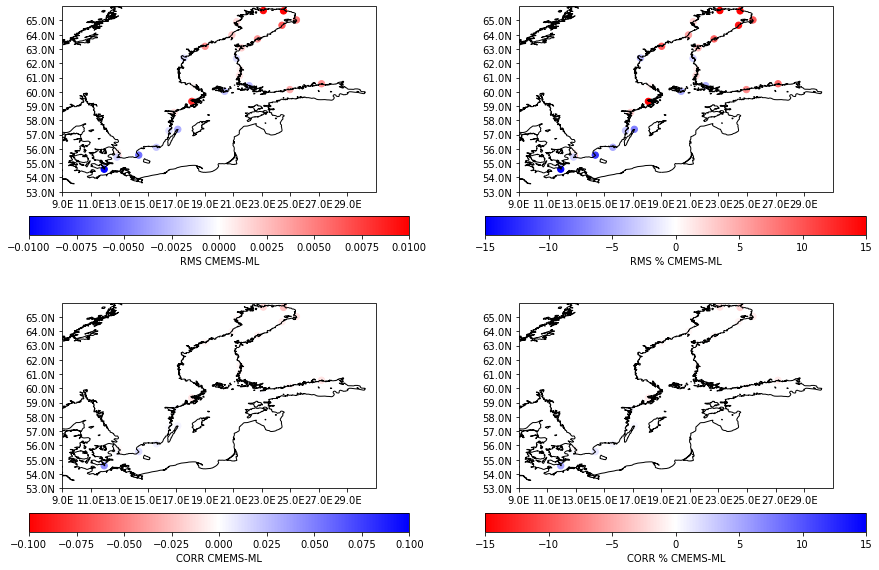

In [7]:
# FUNCTION TO PLOT SINGLE INSTANTANEOUS MAPS -  to be externalised

def single_plot(rms_cmemsvsML_plot,min_sl,max_sl,counter,row_total,col_total,fig,min_lat,max_lat,min_lon,max_lon,label_string,colormap):

    lon = rms_cmemsvsML_plot[0,:]
    lat = rms_cmemsvsML_plot[1,:]
    ssh = rms_cmemsvsML_plot[2,:]   
    
    """Displaying the unstructured grid in a scatterplot:"""
    # 

    #fig = plt.plot()
    #plt.rcParams.update({'font.size': 15})
    #plt.plot
    #plt.rcParams["figure.figsize"] = (50,10) #Increase figure size
    ax=fig.add_subplot(row_total,col_total,counter,projection=ccrs.PlateCarree())
    
    ax.set_xticks(np.arange(min_lon,max_lon,2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(min_lat,max_lat,1), crs=ccrs.PlateCarree())    
    
    #ax = plt.axes(projection=ccrs.Miller()) 
    img=plt.scatter(lon, lat, c=ssh, s=40, cmap=colormap, alpha=1) 
    ax.coastlines(resolution='10m', color='black', linewidth=1) 
    plt.xlim(min_lon,max_lon)

    lon_formatter = cart.mpl.ticker.LongitudeFormatter(number_format='.1f', 
                                      degree_symbol='', 
                                      dateline_direction_label=True)
    lat_formatter = cart.mpl.ticker.LatitudeFormatter(number_format='.1f', 
                                     degree_symbol='')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter) 
    plt.colorbar(img,label=label_string,orientation = 'horizontal',pad = 0.1)
    plt.clim(min_sl, max_sl)
    
    ax.set_extent([min_lon,max_lon,min_lat,max_lat,])
    #plt.show() #a window will show up, allowing the user to see and download the plot
    
    return 







# Absolute differences in RMS, Correlation and standard deviation
rms_cmemsvsML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),rms_cmems-rms_ML,])
corr_cmemsvsML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),corr_cmems-corr_ML,])

# Percentage differences in RMS and Correlation
rms_pc_cmemsvsML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),((rms_cmems-rms_ML)/rms_ML)*100,])
corr_pc_cmemsvsML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),((corr_cmems-corr_ML)/corr_ML)*100,])


fig = plt.figure(figsize = (15, 10))

min_sl = -0.01
max_sl = 0.01
single_plot(rms_cmemsvsML_plot,min_sl,max_sl,1,2,2,fig,min_lat,max_lat,min_lon,max_lon,r'RMS CMEMS-ML','bwr')

min_sl = -15
max_sl = 15
single_plot(rms_pc_cmemsvsML_plot,min_sl,max_sl,2,2,2,fig,min_lat,max_lat,min_lon,max_lon,r'RMS % CMEMS-ML','bwr')

min_sl = -0.10
max_sl = 0.10
single_plot(corr_cmemsvsML_plot,min_sl,max_sl,3,2,2,fig,min_lat,max_lat,min_lon,max_lon,r'CORR CMEMS-ML','bwr_r')

min_sl = -15
max_sl = 15
single_plot(corr_pc_cmemsvsML_plot,min_sl,max_sl,4,2,2,fig,min_lat,max_lat,min_lon,max_lon,r'CORR % CMEMS-ML','bwr_r')


# fig = plt.figure(figsize = (15, 10))
# ax = plt.axes(projection=ccrs.PlateCarree()) 
# ax.coastlines(resolution='10m', color='black', linewidth=1) 

# ax.set_xticks(np.arange(min_lon,max_lon,2), crs=ccrs.PlateCarree())
# ax.set_yticks(np.arange(min_lat,max_lat,1), crs=ccrs.PlateCarree())


# ax.set_extent([min_lon,max_lon,min_lat,max_lat,])

# scat = plt.scatter(rms_cmemsvsML_plot[0,:], rms_cmemsvsML_plot[1,:], c = rms_cmemsvsML_plot[2,:], edgecolor = 'none', alpha = 1, zorder = 3,s=80,
#                   vmin=-0.02, vmax=0.02,cmap='bwr')


# lon_formatter = cart.mpl.ticker.LongitudeFormatter(number_format='.1f', 
#                                   degree_symbol='', 
#                                   dateline_direction_label=True)
# lat_formatter = cart.mpl.ticker.LatitudeFormatter(number_format='.1f', 
#                                  degree_symbol='')
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter) 
# plt.colorbar(scat,label=r'RMS CMEMS - ML (m)')
# plt.clim(-0.01, 0.01)

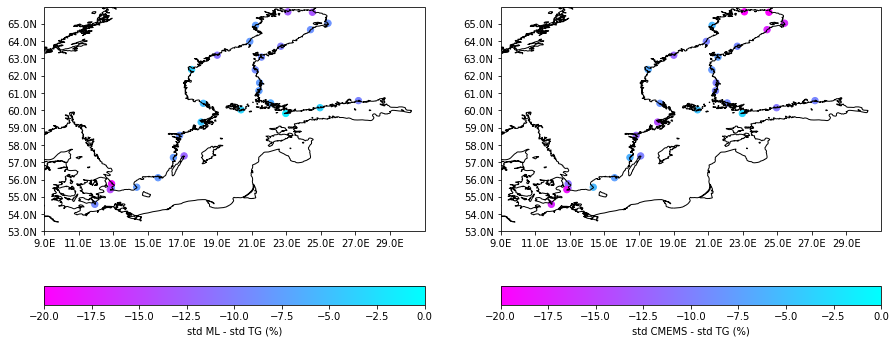

In [8]:
#Standard Deviations

stddiff_ML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),(std_ML-std_tg)/std_tg *100,])

stddiff_cmems_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),(std_cmems-std_tg)/std_tg *100,])


fig = plt.figure(figsize = (15, 10))

min_sl = -20
max_sl = 0
single_plot(stddiff_ML_plot ,min_sl,max_sl,1,1,2,fig,min_lat,max_lat,min_lon,max_lon,r'std ML - std TG (%)','cool_r')


single_plot(stddiff_cmems_plot,min_sl,max_sl,2,1,2,fig,min_lat,max_lat,min_lon,max_lon,r'std CMEMS - std TG (%)','cool_r')


#### 

In [9]:
# Correlation
np.nanmean((corr_ML - corr_cmems) / corr_cmems * 100)


0.11234908413890421

In [10]:
# RMS
np.nanmean((rms_ML - rms_cmems) / rms_cmems *100)

-2.1789556446912544

In [11]:
# STD
#Average misrepresented signal in ML
misrepresented_signal_ML = np.nanmean( (std_ML-std_tg)/std_tg *100) 

#Average misrepresented signal in cmems
misrepresented_signal_cmems = np.nanmean( (std_cmems-std_tg)/std_tg *100) 

np.nanmean( (std_ML-std_tg)/std_tg *100 - (std_cmems-std_tg)/std_tg *100)

2.5062149893618333

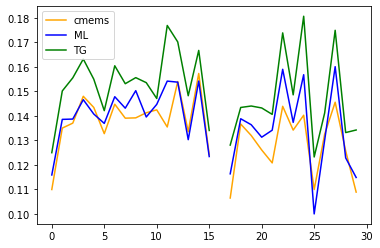

In [12]:
plt.plot(std_cmems,label="cmems",color='orange')
plt.plot(std_ML,label="ML",color='blue')
plt.plot(std_tg,label="TG",color='green')
#plt.plot((std_ML-std_tg)/std_tg *100)
#plt.plot((std_cmems-std_tg)/std_tg *100)
plt.legend()